In [1]:
import keras, os, time
from __future__ import division
from __future__ import print_function
from models_def import build_celebA_model
from data import get_celebA_data
from utils import estimate_ipt_celebA, get_super_resol_A, get_inpaint_A
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import pickle
%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.


## Train / Load DAE

In [2]:
#Build Model Graph
autoencoder = build_celebA_model()

In [3]:
#Get original train data (160000 images)
#x_train = get_celebA_data(train=True, train_data_dir='img_align_celeba/train/data/')

#Add noise for training 
#x_train_noisy = np.zeros(x_train.shape, dtype=np.float32)

#train
#x_train_noisy[:32000] = x_train[:32000] + 0.25*np.random.normal(loc=0.0, scale=1.0, size=(32000,64,64,3)) 
#x_train_noisy[32000:2*32000] = x_train[32000:2*32000] + 0.50*np.random.normal(loc=0.0, scale=1.0, size=(32000,64,64,3)) 
#x_train_noisy[2*32000:3*32000] = x_train[2*32000:3*32000] + 0.75*np.random.normal(loc=0.0, scale=1.0, size=(32000,64,64,3)) 
#x_train_noisy[3*32000:4*32000] = x_train[3*32000:4*32000] + 1.0*np.random.normal(loc=0.0, scale=1.0, size=(32000,64,64,3)) 
#x_train_noisy[4*32000:5*32000] = x_train[4*32000:5*32000] + 1.25*np.random.normal(loc=0.0, scale=1.0, size=(32000,64,64,3)) 

In [4]:
#Train model and save to disk
#%%capture training
#lr = 0.01
#autoencoder.compile(optimizer=keras.optimizers.Adam(lr), loss='mean_squared_error')
#autoencoder.fit(x_train_noisy, x_train,
#                epochs=400,
#                batch_size=128,
#                shuffle=True,
#                validation_data=(x_train_noisy[145000:150000], x_train[145000:150000]),)

#Note that you can use a separate validation set that is not part of the train set. 

#model_json = autoencoder.to_json()
#with open("celebA_autoencoder_full_data", "w") as json_file:
#    json_file.write(model_json)
    # serialize weights to HDF5
#    autoencoder.save_weights("celebA_autoencoder_full_data_weights")
#    print("Saved model to disk")

In [5]:
#Load model as per the saved file name above
model_def_file = 'models/celebA/celebA_autoencoder_full_data'
model_weight_file = 'models/celebA/celebA_autoencoder_full_data_weights'
json_file = open(model_def_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
autoencoder.load_weights(model_weight_file)
print("Loaded model from disk")

Loaded model from disk


## Test DAE  on Noisy Images

In [6]:
x_test = get_celebA_data(test=True, test_data_dir='./data/celebA/')

#Add noise for training 
x_test_noisy = np.zeros(x_test.shape, dtype=np.float32)
x_test_noisy = x_test + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 


In [7]:
x_preds = autoencoder.predict(x_test_noisy)

## Original Test Images

[58 20  3  8 21 32 25 40 39 23]


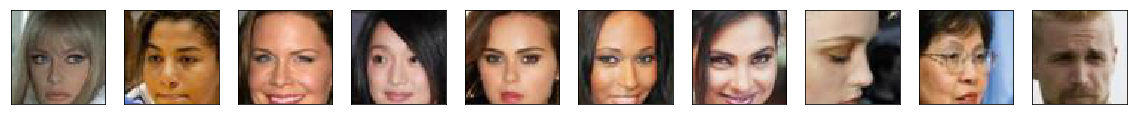

In [8]:
x_vis = np.random.choice(range(64), size=10, replace=False)
print(x_vis)
plt.figure(figsize=(20, 2))
ctr =1
for i in x_vis:
    ax = plt.subplot(1, 10, ctr)
    plt.imshow(x_test[i].flatten().reshape(64,64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ctr+=1
plt.show()

## Noisy Test Images

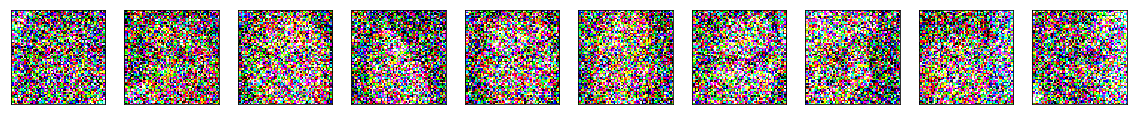

In [9]:
plt.figure(figsize=(20, 2))
ctr =1
for i in x_vis:
    ax = plt.subplot(1, 10, ctr)
    plt.imshow(x_test_noisy[i].flatten().reshape(64,64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ctr+=1
plt.show()

## Denoised Test Images

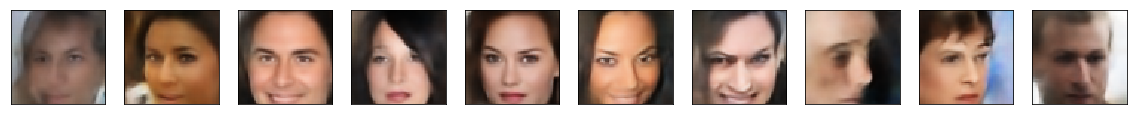

In [10]:
plt.figure(figsize=(20, 2))
ctr =1
for i in x_vis:
    ax = plt.subplot(1, 10, ctr)
    plt.imshow(x_preds[i].flatten().reshape(64,64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ctr+=1
plt.show()

## Compressive Sensing: No Noise

In [11]:
x_test_task = [182674, 182665, 182692, 182681, 182645, 182667, 182640,182694,182699, 182679]

## Algorithm 1 : IPT

In [12]:
results_dir = 'results/cs_no_noise/celebA/'
norm_diff = {}
time_diff = {} #turn off visualization when using measuring time comnplexity
for m in [250,500,750,1000,1500,2000]:
    A = (np.random.normal(0, 1/np.sqrt(m), (m, 12288)))
    y = np.zeros((10,m))
    ctr = 0
    for i in x_test_task:
        y[ctr] = np.dot(A, x_test[i - 182638].flatten())
        ctr+=1

    iterations = 10 
    num_test = 10
    A_T = A.T
    norm_diff[m] = num_test*[0.]
    time_diff[m] = num_test*[0.]
    print("Using m={}".format(m))
    for i in range(num_test):
        print("Test Image Name: {}.jpg".format(x_test_task[i]))
        x_est, time_diff[m][i] = estimate_ipt_celebA(A, A_T, y[i], autoencoder, iterations)
        norm_diff[m][i] = np.linalg.norm(x_est.flatten() - x_test[x_test_task[i] -182638 ].flatten())
        im = Image.fromarray((x_est * 255).astype(np.uint8))
        im.save(results_dir + '{}/{}.png'.format(m,x_test_task[i]))
        
with open(results_dir + 'norm_diffs.pickle', 'wb') as handle:
    pickle.dump(norm_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(results_dir + 'time_diffs.pickle', 'wb') as handle:
    pickle.dump(time_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

Using m=250
Test Image Name: 182674.jpg
Test Image Name: 182665.jpg
Test Image Name: 182692.jpg
Test Image Name: 182681.jpg
Test Image Name: 182645.jpg
Test Image Name: 182667.jpg
Test Image Name: 182640.jpg
Test Image Name: 182694.jpg
Test Image Name: 182699.jpg
Test Image Name: 182679.jpg
Using m=500
Test Image Name: 182674.jpg
Test Image Name: 182665.jpg
Test Image Name: 182692.jpg
Test Image Name: 182681.jpg
Test Image Name: 182645.jpg
Test Image Name: 182667.jpg
Test Image Name: 182640.jpg
Test Image Name: 182694.jpg
Test Image Name: 182699.jpg
Test Image Name: 182679.jpg
Using m=750
Test Image Name: 182674.jpg
Test Image Name: 182665.jpg
Test Image Name: 182692.jpg
Test Image Name: 182681.jpg
Test Image Name: 182645.jpg
Test Image Name: 182667.jpg
Test Image Name: 182640.jpg
Test Image Name: 182694.jpg
Test Image Name: 182699.jpg
Test Image Name: 182679.jpg
Using m=1000
Test Image Name: 182674.jpg
Test Image Name: 182665.jpg
Test Image Name: 182692.jpg
Test Image Name: 182681.jpg

## Compressive Sensing: With Noise

In [13]:
results_dir = 'results/cs_noise/celebA/'
norm_diff = {}
time_diff = {} #turn off visualization when using measuring time comnplexity
for m in [250,500,750,1000,1500,2000]:
    A = (np.random.normal(0, 1/np.sqrt(m), (m, 12288)))
    y = np.zeros((10,m))
    ctr = 0
    for i in x_test_task:
        y[ctr] = np.dot(A, x_test[i - 182638].flatten()) + np.random.normal(loc=0., scale=0.5, size=m)
        ctr+=1

    iterations = 10 
    num_test = 10
    A_T = A.T
    norm_diff[m] = num_test*[0.]
    time_diff[m] = num_test*[0.]
    print("Using m={}".format(m))
    for i in range(num_test):
        print("Test Image Name: {}.jpg".format(x_test_task[i]))
        x_est, time_diff[m][i] = estimate_ipt_celebA(A, A_T, y[i], autoencoder, iterations)
        norm_diff[m][i] = np.linalg.norm(x_est.flatten() - x_test[x_test_task[i] -182638 ].flatten())
        im = Image.fromarray((x_est * 255).astype(np.uint8))
        im.save(results_dir + '{}/{}.png'.format(m,x_test_task[i]))
        
with open(results_dir + 'norm_diffs.pickle', 'wb') as handle:
    pickle.dump(norm_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(results_dir + 'time_diffs.pickle', 'wb') as handle:
    pickle.dump(time_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

Using m=250
Test Image Name: 182674.jpg
Test Image Name: 182665.jpg
Test Image Name: 182692.jpg
Test Image Name: 182681.jpg
Test Image Name: 182645.jpg
Test Image Name: 182667.jpg
Test Image Name: 182640.jpg
Test Image Name: 182694.jpg
Test Image Name: 182699.jpg
Test Image Name: 182679.jpg
Using m=500
Test Image Name: 182674.jpg
Test Image Name: 182665.jpg
Test Image Name: 182692.jpg
Test Image Name: 182681.jpg
Test Image Name: 182645.jpg
Test Image Name: 182667.jpg
Test Image Name: 182640.jpg
Test Image Name: 182694.jpg
Test Image Name: 182699.jpg
Test Image Name: 182679.jpg
Using m=750
Test Image Name: 182674.jpg
Test Image Name: 182665.jpg
Test Image Name: 182692.jpg
Test Image Name: 182681.jpg
Test Image Name: 182645.jpg
Test Image Name: 182667.jpg
Test Image Name: 182640.jpg
Test Image Name: 182694.jpg
Test Image Name: 182699.jpg
Test Image Name: 182679.jpg
Using m=1000
Test Image Name: 182674.jpg
Test Image Name: 182665.jpg
Test Image Name: 182692.jpg
Test Image Name: 182681.jpg

## Superresolution

In [14]:
x_test_task = [182639, 182697, 182694, 182658, 182687, 182695, 182676, 182690,182675,182686]

Using m=2
Test Image Name: 182639.jpg


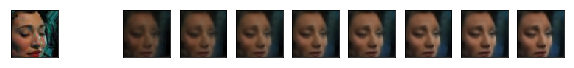

Test Image Name: 182697.jpg


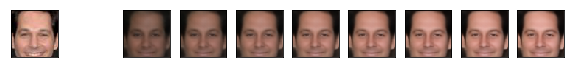

Test Image Name: 182694.jpg


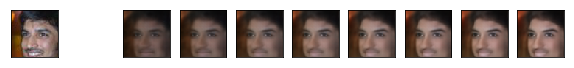

Test Image Name: 182658.jpg


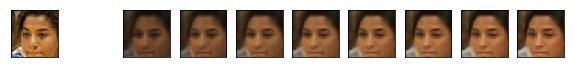

Test Image Name: 182687.jpg


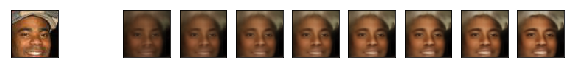

Test Image Name: 182695.jpg


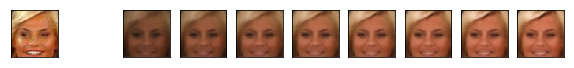

Test Image Name: 182676.jpg


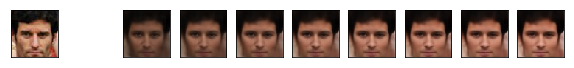

Test Image Name: 182690.jpg


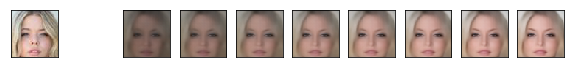

Test Image Name: 182675.jpg


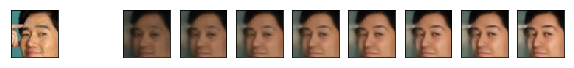

Test Image Name: 182686.jpg


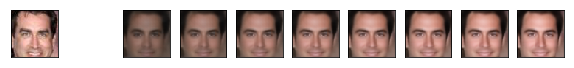

Using m=3
Test Image Name: 182639.jpg


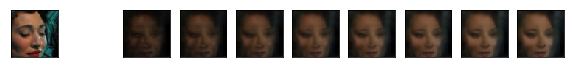

Test Image Name: 182697.jpg


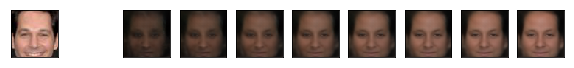

Test Image Name: 182694.jpg


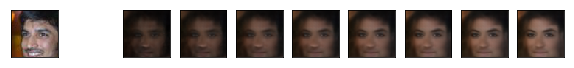

Test Image Name: 182658.jpg


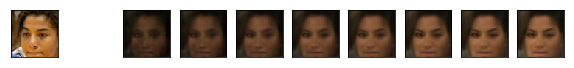

Test Image Name: 182687.jpg


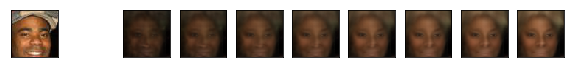

Test Image Name: 182695.jpg


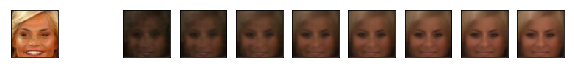

Test Image Name: 182676.jpg


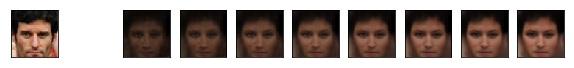

Test Image Name: 182690.jpg


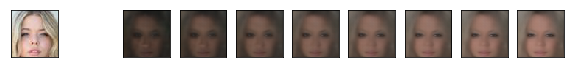

Test Image Name: 182675.jpg


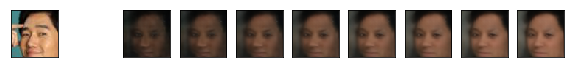

Test Image Name: 182686.jpg


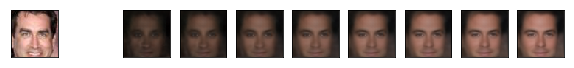

Using m=4
Test Image Name: 182639.jpg


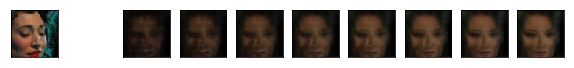

Test Image Name: 182697.jpg


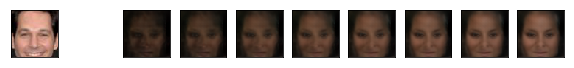

Test Image Name: 182694.jpg


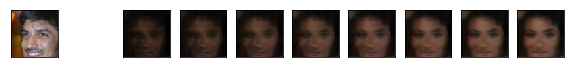

Test Image Name: 182658.jpg


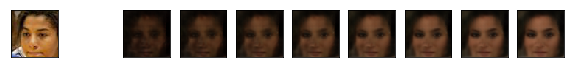

Test Image Name: 182687.jpg


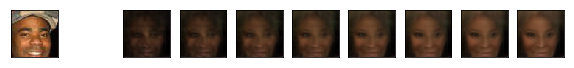

Test Image Name: 182695.jpg


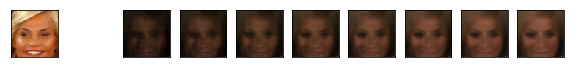

Test Image Name: 182676.jpg


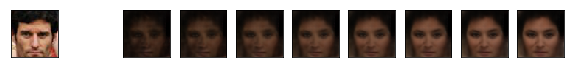

Test Image Name: 182690.jpg


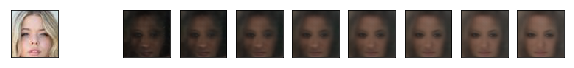

Test Image Name: 182675.jpg


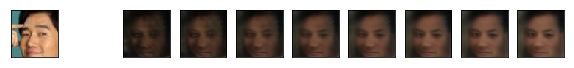

Test Image Name: 182686.jpg


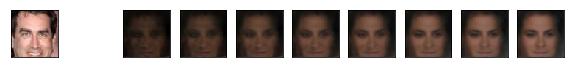

In [16]:
results_dir = 'results/superresolution/celebA/'
norm_diff = {}
for m in [2,3,4]:
    A = get_super_resol_A(m)
    y = np.zeros((10,int(64/m)**2*3))
    ctr = 0
    for i in x_test_task:
        y[ctr] = np.dot(A, x_test[i - 182638].flatten())
        ctr+=1


    iterations = 10 
    num_test = 10
    A_T = A.T
    norm_diff[m] = num_test*[0.]
    print("Using m={}".format(m))
    for i in range(num_test):
        print("Test Image Name: {}.jpg".format(x_test_task[i]))
        x_est, _ = estimate_ipt_celebA(A, A_T, y[i], autoencoder, iterations, visualize=True,x=x_test[x_test_task[i] - 182638])
        norm_diff[m][i] = np.linalg.norm(x_est.flatten() - x_test[x_test_task[i] -182638 ].flatten())
        im = Image.fromarray((x_est * 255).astype(np.uint8))
        im.save(results_dir + '{}/{}.png'.format(m,x_test_task[i]))
        
with open(results_dir + 'norm_diffs.pickle', 'wb') as handle:
    pickle.dump(norm_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Inpainting

In [17]:
x_test_task = [182689, 182669, 182652, 182655, 182664, 182681, 182688, 182675,182674,182698]

Using m=10
Test Image Name: 182689.jpg


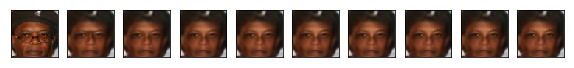

Test Image Name: 182669.jpg


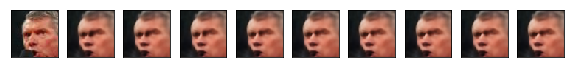

Test Image Name: 182652.jpg


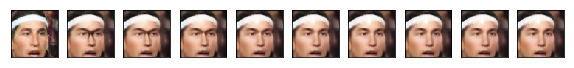

Test Image Name: 182655.jpg


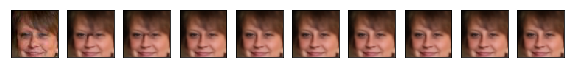

Test Image Name: 182664.jpg


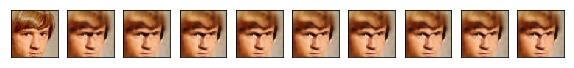

Test Image Name: 182681.jpg


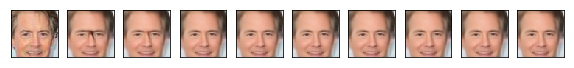

Test Image Name: 182688.jpg


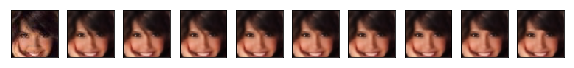

Test Image Name: 182675.jpg


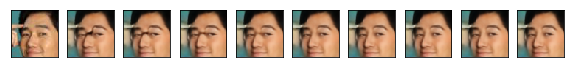

Test Image Name: 182674.jpg


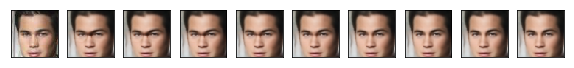

Test Image Name: 182698.jpg


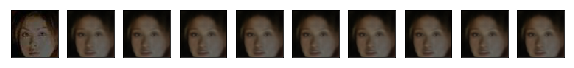

Using m=15
Test Image Name: 182689.jpg


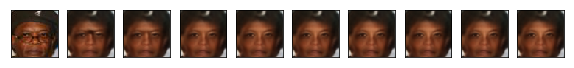

Test Image Name: 182669.jpg


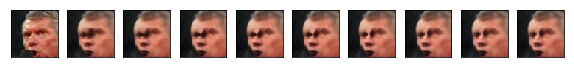

Test Image Name: 182652.jpg


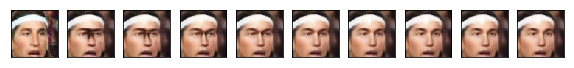

Test Image Name: 182655.jpg


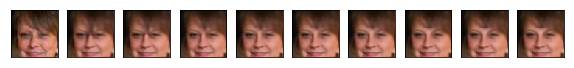

Test Image Name: 182664.jpg


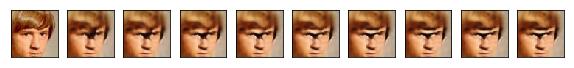

Test Image Name: 182681.jpg


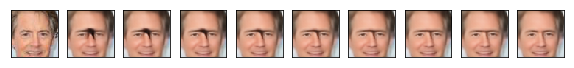

Test Image Name: 182688.jpg


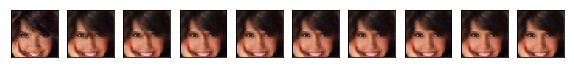

Test Image Name: 182675.jpg


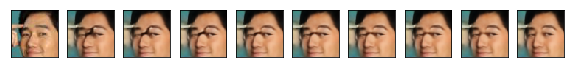

Test Image Name: 182674.jpg


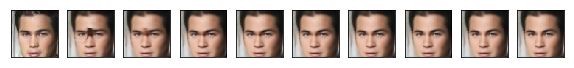

Test Image Name: 182698.jpg


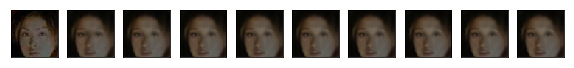

Using m=20
Test Image Name: 182689.jpg


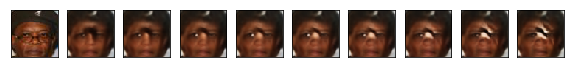

Test Image Name: 182669.jpg


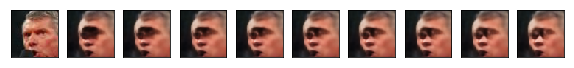

Test Image Name: 182652.jpg


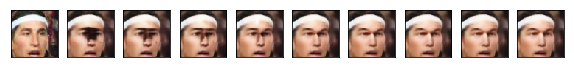

Test Image Name: 182655.jpg


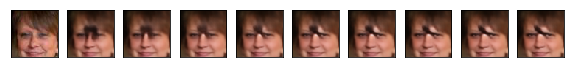

Test Image Name: 182664.jpg


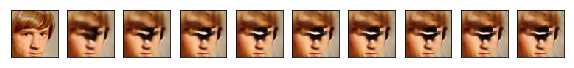

Test Image Name: 182681.jpg


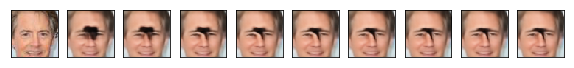

Test Image Name: 182688.jpg


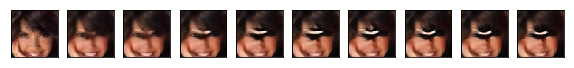

Test Image Name: 182675.jpg


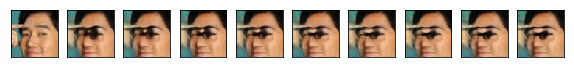

Test Image Name: 182674.jpg


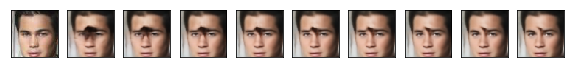

Test Image Name: 182698.jpg


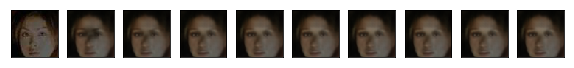

Using m=25
Test Image Name: 182689.jpg


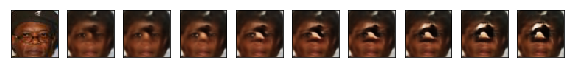

Test Image Name: 182669.jpg


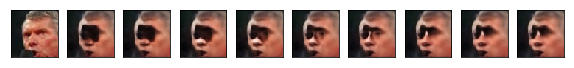

Test Image Name: 182652.jpg


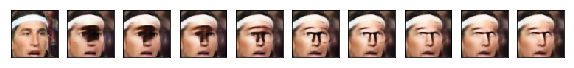

Test Image Name: 182655.jpg


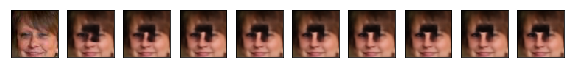

Test Image Name: 182664.jpg


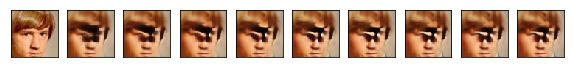

Test Image Name: 182681.jpg


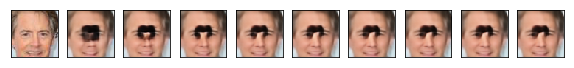

Test Image Name: 182688.jpg


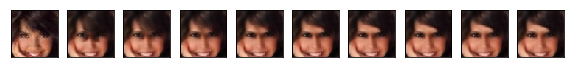

Test Image Name: 182675.jpg


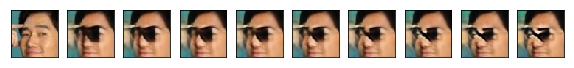

Test Image Name: 182674.jpg


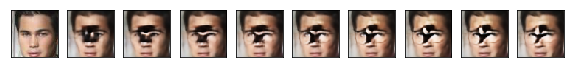

Test Image Name: 182698.jpg


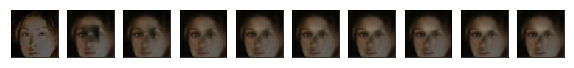

Using m=30
Test Image Name: 182689.jpg


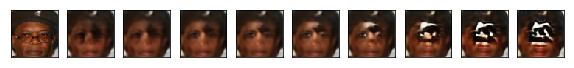

Test Image Name: 182669.jpg


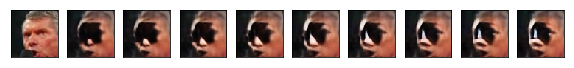

Test Image Name: 182652.jpg


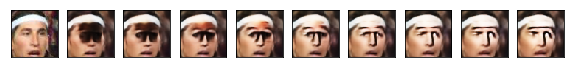

Test Image Name: 182655.jpg


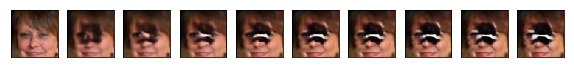

Test Image Name: 182664.jpg


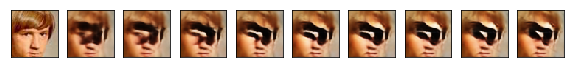

Test Image Name: 182681.jpg


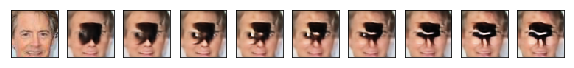

Test Image Name: 182688.jpg


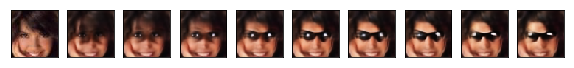

Test Image Name: 182675.jpg


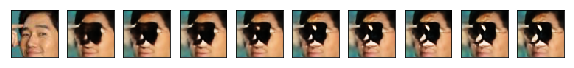

Test Image Name: 182674.jpg


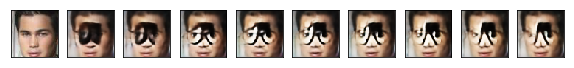

Test Image Name: 182698.jpg


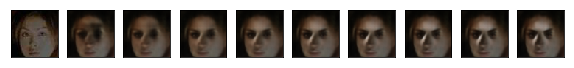

In [18]:
results_dir = 'results/inpainting/celebA/'
norm_diff = {}
for m in [10,15, 20, 25, 30]:
    A = get_inpaint_A(m)
    y = np.zeros((10,12288))
    ctr = 0
    for i in x_test_task:
        y[ctr] = np.dot(A, x_test[i - 182638].flatten())
        ctr+=1

    iterations = 50
    num_test = 10
    A_T = A.T
    norm_diff[m] = num_test*[0.]
    print("Using m={}".format(m))
    for i in range(num_test):
        print("Test Image Name: {}.jpg".format(x_test_task[i]))
        x_est, _ = estimate_ipt_celebA(A, A_T, y[i], autoencoder, iterations, visualize=True,x=x_test[x_test_task[i]-182638])
        norm_diff[m][i] = np.linalg.norm(x_est.flatten() - x_test[x_test_task[i]-182638].flatten())
        im = Image.fromarray((x_est * 255).astype(np.uint8))
        im.save(results_dir + '{}/{}.png'.format(m,x_test_task[i]))
        
with open(results_dir + 'norm_diffs.pickle', 'wb') as handle:
    pickle.dump(norm_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)